# Two-level AMG+ for 1D Helmholtz / Repetitive
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.
* $A^c = P^T A Q$ is constructed locally and tiled, so that there is no fill-in due to $P$ in $P^T A P$.

In [1]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [2]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]

repetitive = True

# Test vectors.
ideal_tv = True #. False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 6
# Set # sweeps manually here.
num_sweeps_on_vectors = 1000 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge"
weighted = True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513015


## Level 0->1 Coarsening

In [3]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
location = [np.arange(n)]

# TV and TV residual history.
x_log = []
r_log = []

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.269e+00                    4.470e-01    2.840
INFO     1     7.058e-01 (0.556) [0.556]    3.500e-01    2.021 (0.711)
INFO     2     4.121e-01 (0.585) [0.570]    3.045e-01    1.359 (0.672)
INFO     3     2.616e-01 (0.635) [0.591]    2.807e-01    0.938 (0.690)
INFO     4     1.830e-01 (0.699) [0.617]    2.662e-01    0.692 (0.738)
INFO     5     1.405e-01 (0.768) [0.645]    2.561e-01    0.553 (0.798)
INFO     6     1.154e-01 (0.821) [0.671]    2.484e-01    0.468 (0.846)
INFO     7     9.939e-02 (0.861) [0.695]    2.422e-01    0.414 (0.883)
INFO     8     8.840e-02 (0.889) [0.717]    2.369e-01    0.376 (0.909)
INFO     9     8.008e-02 (0.905) [0.736]    2.324e-01    0.347 (0.923)
INFO     10    7.360e-02 (0.918) [0.752]    2.283e-01    0.324 (0.935)
INFO     11    6.843e-02 (0.929) [0.767]    2.247e-01    0.306 (0.944)
INFO     12    6.421e-02 (0.938) [0.780]    2.214e-01    0.291 (0.952)
INFO 

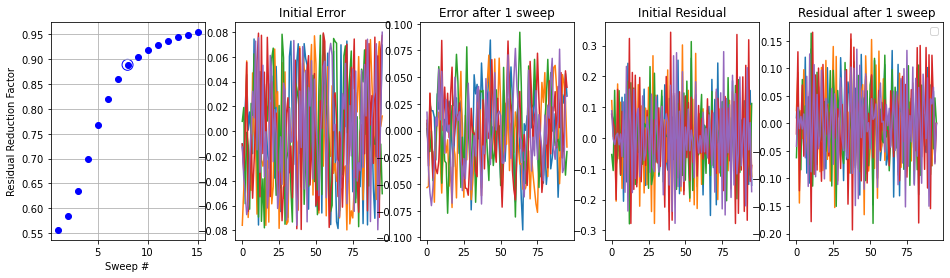

In [4]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95)
num_sweeps = method_info["Kaczmarz"][1]

In [5]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 6 ideal TVs


### Coarsening: Fixed (4/2)

In [6]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

[[-0.406 -0.566 -0.575 -0.429]
 [-0.672 -0.253  0.235  0.656]]


,0,1,2,3,4,5,6,7,8,9
0,-0.41,-0.57,-0.57,-0.43,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.67,-0.25,0.23,0.66,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,-0.41,-0.57,-0.57,-0.43,0.00,0.00
3,0.00,0.00,0.00,0.00,-0.67,-0.25,0.23,0.66,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.41,-0.57


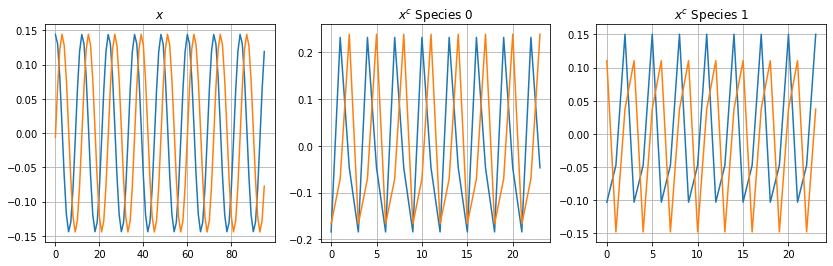

In [7]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

In [8]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.475 0.316 0.185 0.131 0.139 0.1   0.081 0.073]


### Interpolation $P = R^T$

In [9]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy(
            kh, discretization, m * aggregate_size, r.asarray(), p, aggregate_size), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 2.83


### Interpolation by LS Fitting

In [10]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, interpolation_method, aggregate_size=aggregate_size, nc=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, 
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml,  nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
Mock,nan,nan,nan,nan,nan,0.47,0.32,0.18,0.13,0.14,0.10,0.08,0.07
P=R^T,nan,nan,nan,nan,nan,0.52,0.37,0.41,0.41,0.36,0.38,0.37,0.36
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,0.51,0.35,0.38,0.42,0.35,0.36,0.34,0.34
P^T A P caliber 3,0.00,3.00,288.00,1.40,0.00,0.61,0.35,0.29,0.34,0.29,0.26,0.27,0.27
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,0.59,0.32,0.20,0.14,0.14,0.14,0.11,0.07
R A P caliber 2,1.00,2.00,192.00,1.20,0.00,0.51,0.35,0.38,0.42,0.35,0.36,0.33,0.35
R A P caliber 3,1.00,3.00,288.00,1.20,0.00,0.58,0.83,1.01,0.75,0.78,0.87,1.03,0.77
R A P caliber 4,1.00,4.00,384.00,1.20,0.00,0.67,0.39,0.26,0.22,0.18,0.15,0.12,0.09


* The SVD intepolation is good up to $\nu = 2$, conv $\approx 0.36$. This is similar to the case of Laplace + 2/1 coarsening, where $P$ is only first-order.
* Caliber 2 is equivalent to $P = R^T$.
* Caliber 3 is insufficient, oonly gives marginally better convergence than $P = R^T$.
* Caliber 4 Galerkin gives ideal rates (up to $0.11$).
* Caliber 4 $P$ with $R A P$ is slightly non-symmetric but sparser than $P^T A P$. It gives an intermediate performance between $R A R^R$ and $P^T A P$ (up to $0.18$). 

In [11]:
for use_r_as_restriction in (False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")

    for caliber, p in zip(calibers, p_experiment[use_r_as_restriction]):
    #    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
    #    display_html(styler._repr_html_(), raw=True)
        ml = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, None, use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        print("caliber {} P".format(caliber))
        display(pd.DataFrame(p[:aggregate_size, np.unique(p[:aggregate_size].nonzero()[1])].todense()))
        print("A^1")
        display(pd.DataFrame(ac[:num_components, np.unique(ac[:num_components].nonzero()[1])].todense()))
        #ac2 = ac.transpose().dot(ac)
        #display(pd.DataFrame(ac2.todense()[:14,:14]))

P^T*A*P
caliber 2 P


,0,1
0,-0.41,-0.67
1,-0.57,-0.25
2,-0.57,0.23
3,-0.43,0.66


A^1


,0,1,2,3,4,5
0,-0.17,0.02,0.19,0.34,0.19,-0.32
1,0.02,-1.47,-0.32,-0.56,0.34,-0.56


caliber 3 P


,0,1,2,3
0,-0.43,-0.60,0.00,-0.05
1,-0.54,-0.31,0.00,0.04
2,-0.55,0.29,0.04,0.00
3,-0.45,0.59,-0.05,0.00


A^1


,0,1,2,3,4,5,6,7
0,-0.11,0.02,0.19,0.29,0.00,0.00,0.19,-0.27
1,0.02,-1.20,-0.27,-0.44,0.00,0.00,0.29,-0.44


caliber 4 P


,0,1,2,3,4,5
0,-0.37,-0.44,0.00,0.00,-0.11,0.17
1,-0.59,-0.41,0.00,0.00,0.08,-0.11
2,-0.60,0.39,0.07,0.11,0.00,0.00
3,-0.38,0.43,-0.10,-0.17,0.00,0.00


A^1


,0,1,2,3,4,5,6,7,8,9
0,-0.06,0.01,0.16,0.23,0.01,0.01,0.01,-0.01,0.16,-0.21
1,0.01,-0.90,-0.21,-0.31,-0.01,-0.02,0.01,-0.02,0.23,-0.31


R*A*P
caliber 2 P


,0,1
0,-0.41,-0.67
1,-0.57,-0.25
2,-0.57,0.23
3,-0.43,0.66


A^1


,0,1,2,3,4,5
0,-0.17,0.02,0.19,0.34,0.19,-0.32
1,0.02,-1.47,-0.32,-0.56,0.34,-0.56


caliber 3 P


,0,1,2,3
0,-0.43,-0.60,0.00,-0.05
1,-0.54,-0.31,0.00,0.04
2,-0.55,0.29,0.04,0.00
3,-0.45,0.59,-0.05,0.00


A^1


,0,1,2,3,4,5
0,-0.12,0.02,0.19,0.30,0.20,-0.28
1,0.02,-1.30,-0.28,-0.50,0.30,-0.50


caliber 4 P


,0,1,2,3,4,5
0,-0.37,-0.44,0.00,0.00,-0.11,0.17
1,-0.59,-0.41,0.00,0.00,0.08,-0.11
2,-0.60,0.39,0.07,0.11,0.00,0.00
3,-0.38,0.43,-0.10,-0.17,0.00,0.00


A^1


,0,1,2,3,4,5
0,-0.04,0.01,0.15,0.17,0.15,-0.16
1,0.01,-0.62,-0.16,-0.15,0.18,-0.15


In [44]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P.
p = p_experiment[False][-1]

### Solving $Ax = b$ - Convergence History

#### $P^T A P$

INFO         0 |r| 1.616e+01 RER 2.85669
INFO         1 |r| 3.760e+00 (0.23269) RER 0.00000 (0.00000) 2621417736380.142
INFO         2 |r| 8.146e-01 (0.21665) RER 0.00000 (1.70157) 333763869360.390
INFO         3 |r| 1.710e-01 (0.20988) RER 0.00000 (1.05961) 66108817361.984
INFO         4 |r| 4.097e-02 (0.23961) RER 0.00000 (0.82631) 19170137959.169
INFO         5 |r| 8.596e-03 (0.20981) RER 0.00000 (0.64323) 6252989841.706
INFO         6 |r| 2.058e-03 (0.23939) RER 0.00000 (0.97565) 1534232317.054
INFO         7 |r| 4.940e-04 (0.24007) RER 0.00000 (1.57414) 233983967.571
INFO         8 |r| 1.340e-04 (0.27116) RER 0.00000 (1.32695) 47814939.970
INFO         9 |r| 3.316e-05 (0.24755) RER 0.00000 (1.54645) 7653974.353
INFO        10 |r| 9.264e-06 (0.27939) RER 0.00000 (1.29473) 1651622.721
INFO        11 |r| 2.310e-06 (0.24940) RER 0.00000 (0.84452) 487749.433
INFO        12 |r| 6.267e-07 (0.27125) RER 0.00000 (3.61977) 36550.246
INFO        13 |r| 1.635e-07 (0.26087) RER 0.00000 (0.7567

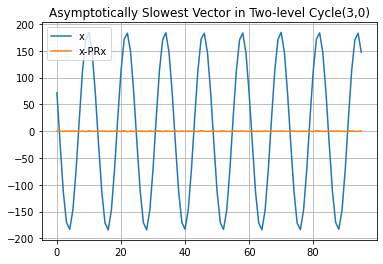

In [12]:
nu = 3
multilevel = hm.repetitive.locality.create_two_level_hierarchy(
    kh, discretization, n, R, p, aggregate_size, use_r_as_restriction=True)

# Calculate coarse-level variable locations. At each aggregate center we have 'num_components' coarse variables.
location[1] = np.tile(np.add.reduceat(location[0], np.arange(0, n, aggregate_size)) / aggregate_size, 
                      (num_components, 1)).transpose().flatten()

y, _ = hm.repetitive.locality.two_level_conv_factor(multilevel, nu, print_frequency=1,
                                                   debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [13]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:12])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel[k].p.dot(v)
    vl_finest.append(v)

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [ 0.     0.     0.064  0.064 -0.072 -0.072  0.119  0.119 -0.152 -0.152  0.163  0.163]


#### $P^T A Q$ Coarsening
This is not exactly $P^T A Q$, since $Q$ is not a uni-valued operator. It maps a point at the edge of the stencil of $P^T A$ to two values, one when it's at the edge and one when it's in the middle of the stencil.

In [14]:
a = multilevel.finest_level.a
p = multilevel[1].p

pta = p.transpose().dot(a)
print("nnz in P^T*A stencil", pta[0].nnz)
i = 0
pta_vars = np.sort(pta[i].nonzero()[1])
print("center", i)
print("pta_vars", pta_vars)
print("stencil values", np.array(pta[i, pta[i].nonzero()[1]].todense()))
#pd.DataFrame(pta.todense()[:5])

# P^T*A*R^T sparsity pattern.
rap = pta.dot(R.transpose())
rap_vars = np.sort(rap[i].nonzero()[1])
print("rap_vars", rap_vars)

fine_location, coarse_location = location[0:2]

# Find P^T*A fine and coarse var locations. Wrapping works on locations a well even
# though they are not integers (apply periodic B.C. so distances don't wrap around).
xf = hm.setup.sampling.wrap_index_to_low_value(fine_location[pta_vars], n)
xc = hm.setup.sampling.wrap_index_to_low_value(coarse_location[rap_vars], n)

# Find nearest neighbors of each fine P^T*A point (pta_vars).
# These are INDICES into the rap_vars array.
nbhr = np.argsort(np.abs(xf[:, None] - xc), axis=1)
print("nbhr", nbhr)

nnz in P^T*A stencil 12
center 0
pta_vars [ 0  1  2  3  4  5  6  7 92 93 94 95]
stencil values [[-0.053  0.056  0.083 -0.047 -0.122 -0.281  0.112 -0.006 -0.006  0.107 -0.267 -0.121]]
rap_vars [ 0  1  2  3 46 47]
nbhr [[0 1 4 5 2 3]
 [0 1 4 5 2 3]
 [0 1 2 3 4 5]
 [0 1 2 3 4 5]
 [2 3 0 1 4 5]
 [2 3 0 1 4 5]
 [2 3 0 1 4 5]
 [2 3 0 1 4 5]
 [4 5 0 1 2 3]
 [4 5 0 1 2 3]
 [4 5 0 1 2 3]
 [4 5 0 1 2 3]]


In [15]:
caliber = 4
max_caliber = 6

nc = num_components
num_aggregates = int(np.ceil(a.shape[0] / aggregate_size))
num_coarse_vars = nc * num_aggregates
domain_size, num_test_functions = x.shape

# Prepare fine and coarse test matrices.
xc = R.dot(x)
residual = a.dot(x)

# Prepare sampled windows of x, xc, residual normn.
max_caliber = min(max_caliber, max(len(n) for n in nbhr))
num_windows = max(np.minimum(num_aggregates, (12 * max_caliber) // num_test_functions), 1)
x_disjoint_aggregate_t = hm.setup.sampling.get_windows_by_index(x, pta_vars, aggregate_size, num_windows)
xc_disjoint_aggregate_t = hm.setup.sampling.get_windows_by_index(xc, rap_vars, num_components, num_windows)

# Calculate residual norms.
index = pta_vars
stride = aggregate_size
residual_window_size = 3 * aggregate_size  # Good for 1D.
residual_window_offset = -(residual_window_size // 2)
r_norm_disjoint_aggregate_t = np.concatenate(tuple(
np.linalg.norm(
    residual[int(np.rint(np.mean(
        hm.setup.sampling.wrap_index_to_low_value(index + offset, n)
    ))) + residual_window_offset + 
             np.arange(residual_window_size) % residual.shape[0]],
    axis=0) 
    for offset in range(0, num_windows * stride, stride))) / residual_window_size ** 0.5
# In principle, each point in the aggregate should have a slightly shifted residual window, but we just take the
# same residual norm for all points for simplicity. Should not matter much.
r_norm_disjoint_aggregate_t = np.tile(r_norm_disjoint_aggregate_t[:, None], (len(index), ))

weight = np.clip(r_norm_disjoint_aggregate_t, 1e-15, None) ** (-1)
    
nbhr_for_caliber = [n[:caliber] for n in nbhr]

# Create folds.
num_samples = int(x_disjoint_aggregate_t.shape[0])
num_ls_examples = num_samples - num_test_examples
val_samples = int(0.2 * num_ls_examples)
fit_samples = num_samples - val_samples - num_test_examples

# Ridge regularization parameter (list of values).
alpha = np.array([0, 0.01, 0.1, 0.1, 1])

q = hm.setup.interpolation_ls_fit.create_interpolation_least_squares_ridge(
    x_disjoint_aggregate_t, xc_disjoint_aggregate_t, nbhr_for_caliber, weight, 
    alpha=alpha, fit_samples=fit_samples,
    val_samples=val_samples, test_samples=num_test_examples)

#x_disjoint_aggregate_t.shape, xc_disjoint_aggregate_t.shape, weight.shape

print("q", q.todense())

ptaq = pta[:num_components, pta_vars].dot(q)
print("ptaq", ptaq.todense())

print("ac", ac[10:12, 8:14].todense())

q [[-0.367 -0.442  0.     0.    -0.106  0.172]
 [-0.587 -0.413  0.     0.     0.077 -0.111]
 [-0.601  0.394  0.074  0.114  0.     0.   ]
 [-0.382  0.43  -0.1   -0.174  0.     0.   ]
 [-0.104  0.168 -0.368 -0.446  0.     0.   ]
 [ 0.077 -0.109 -0.586 -0.412  0.     0.   ]
 [ 0.077 -0.151 -0.617  0.055  0.     0.   ]
 [-0.105  0.185 -0.382  0.891  0.     0.   ]
 [-0.098 -0.186  0.     0.    -0.352 -0.901]
 [ 0.07   0.15   0.     0.    -0.614 -0.079]
 [ 0.074  0.113  0.     0.    -0.6    0.393]
 [-0.099 -0.173  0.     0.    -0.383  0.431]]
ptaq [[-0.045  0.013  0.154  0.188  0.153 -0.175]
 [ 0.013 -0.851 -0.211 -0.253  0.224 -0.252]]
ac [[ 0.147 -0.165 -0.038  0.01   0.147  0.175]
 [ 0.175 -0.152  0.011 -0.62  -0.165 -0.153]]


In [16]:
ac[10:12, 8:14].todense()

matrix([[ 0.147, -0.165, -0.038,  0.01 ,  0.147,  0.175],
        [ 0.175, -0.152,  0.011, -0.62 , -0.165, -0.153]])

In [17]:
nu = 3
p = p_experiment[False][-1]
multilevel = hm.repetitive.locality.create_two_level_hierarchy(
    kh, discretization, n, R, p, aggregate_size, use_r_as_restriction=False)
y, _ = hm.repetitive.locality.two_level_conv_factor(multilevel, nu, print_frequency=1,
                                                   debug=False)


INFO         0 |r| 1.454e+01 RER 2.42670
INFO         1 |r| 2.890e+00 (0.19872) RER 0.52430 (0.21606) 5.512
INFO         2 |r| 5.988e-01 (0.20721) RER 0.10260 (0.19569) 5.836
INFO         3 |r| 9.489e-02 (0.15846) RER 0.01743 (0.16986) 5.445
INFO         4 |r| 1.924e-02 (0.20277) RER 0.00296 (0.16968) 6.507
INFO         5 |r| 3.440e-03 (0.17881) RER 0.00056 (0.18907) 6.153
INFO         6 |r| 6.982e-04 (0.20294) RER 0.00012 (0.21606) 5.780
INFO         7 |r| 1.410e-04 (0.20197) RER 0.00002 (0.20172) 5.787
INFO         8 |r| 2.832e-05 (0.20086) RER 0.00000 (0.19915) 5.836
INFO         9 |r| 5.741e-06 (0.20271) RER 0.00000 (0.19734) 5.995
INFO        10 |r| 1.094e-06 (0.19054) RER 0.00000 (0.17199) 6.642
INFO        11 |r| 2.130e-07 (0.19466) RER 0.00000 (0.18486) 6.994
INFO        12 |r| 4.247e-08 (0.19945) RER 0.00000 (0.22604) 6.171
INFO        13 |r| 8.477e-09 (0.19958) RER 0.00000 (0.21125) 5.830
INFO        14 |r| 1.589e-09 (0.18748) RER 0.00000 (0.17465) 6.259
INFO        15 |r| 3.

In [18]:
ptaq.todense()

matrix([[-0.045,  0.013,  0.154,  0.188,  0.153, -0.175],
        [ 0.013, -0.851, -0.211, -0.253,  0.224, -0.252]])

In [19]:
k = hm.linalg.tile_csr_matrix(ptaq, n // aggregate_size, stride=num_components, total_col=multilevel[1].size)

In [20]:
i = scipy.sparse.csr_matrix(np.arange(1, 13).reshape((2, 6)))
n = 4
stride = 2
total_col = 12

n_row, n_col = i.shape
row, col = i.nonzero()
data = i.data

# Calculate the positions of stencil neighbors relative to the stencil center.
relative_col = col
relative_col = col - row
relative_col[relative_col >= n_col // 2] -= n_col
relative_col[relative_col < -(n_col // 2)] += n_col
print(relative_col)

tiled_data = np.tile(data, n)
tiled_row = np.concatenate([row + i * n_row for i in range(n)])
tiled_col = np.concatenate([(row + relative_col + j * stride) % total_col for j in range(n)])

k = scipy.sparse.coo_matrix((tiled_data, (tiled_row, tiled_col)), shape=(n * n_row, total_col)).tocsr()
#k = hm.linalg.tile_csr_matrix(i, 4, stride=2, total_col=12)

[ 0  1  2 -3 -2 -1 -1  0  1  2 -3 -2]


In [21]:
pd.DataFrame(k.todense())

,0,1,2,3,4,5,6,7,8,9,10,11
0,1,2,3,0,0,0,0,0,0,4,5,6
1,7,8,9,10,0,0,0,0,0,0,11,12
2,5,6,1,2,3,0,0,0,0,0,0,4
3,11,12,7,8,9,10,0,0,0,0,0,0
4,0,4,5,6,1,2,3,0,0,0,0,0
5,0,0,11,12,7,8,9,10,0,0,0,0
6,0,0,0,4,5,6,1,2,3,0,0,0
7,0,0,0,0,11,12,7,8,9,10,0,0


In [22]:
display(pd.DataFrame(p[:aggregate_size, np.unique(p[:aggregate_size].nonzero()[1])].todense()))

,0,1,2,3,4,5
0,-0.37,-0.44,0.00,0.00,-0.11,0.17
1,-0.59,-0.41,0.00,0.00,0.08,-0.11
2,-0.60,0.39,0.07,0.11,0.00,0.00
3,-0.38,0.43,-0.10,-0.17,0.00,0.00


## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [23]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

## Level 1 Relaxation

We run relaxation on $A x = 0$. $A$ has two null vectors; call $Y$ the $n \times 2$ matrix whose columns are these vectors. Let $x_0$ be a random[-1, 1] initial guess for $x$. We first project $x_0$ onto the range of $A$, that is,

$x_0 \longleftarrow x_0 - Y Y^T x_0^T\,,$

and use this as the initial guess for the run. Since the magnitude of $Y$ the exact solution is $0$, and relaxation doesn't change this magnitude, $e = x - x_0$ is a meaningful definition, which can also be used to calculate a meaningful RER.

A symmetry deviation 1.1102230246251565e-16
lam [ 0.    -0.     0.064  0.064 -0.072 -0.072  0.119  0.119 -0.153 -0.153]
Y^T Y coming out of eig() [[ 1.    -0.127]
 [-0.127  1.   ]]
Y^T Y after Grahm-Schmidt [[1. 0.]
 [0. 1.]]
|imag(y)| 0.0
A*y [0. 0.]


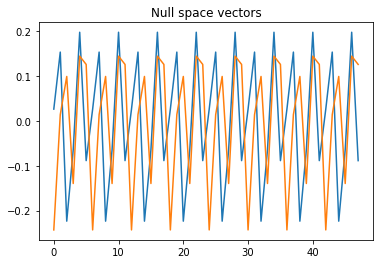

In [34]:
m1 = multilevel.sub_hierarchy(1)
level = m1.finest_level
a = level.a
lam, v = eig(a.todense())
# If A is real, it has an orthogonal set of eigenvectors.
print("A symmetry deviation", np.max(a - a.T))

lam = np.real(lam)
ind = np.argsort(np.abs(lam))
lam = lam[ind]
v = v[:, ind]
y = v[:, :2]  # normalized, but may not be orthogonal.
print("lam", lam[:10])
print("Y^T Y coming out of eig()", np.real(y.T.dot(y)))

# After Grahm-Schmidt, y is also real.
y[:, 1] -= (y[:, 0].dot(y[:, 1])) * y[:, 0]
y[:, 1] /= norm(y[:, 1])
print("Y^T Y after Grahm-Schmidt", np.real(y.T.dot(y)))
print("|imag(y)|", norm(np.imag(y)))
y = np.real(y)
print("A*y", norm(a.dot(y), axis=0))
plt.plot(y[:, 0])
plt.plot(y[:, 1])
plt.title("Null space vectors");

In [35]:
# Prepare initial guess that's orthogonal to the null space of A1.
x0 = hm.solve.run.random_test_matrix((a.shape[0], ), num_examples=5)
print(y.T.dot(x0))
x = x0 - y.dot(y.T.dot(x0))
print("y.dot(x)", y.T.dot(x))

[[-0.11  -0.062  0.05  -0.063  0.05 ]
 [-0.045 -0.01   0.084  0.082  0.132]]
y.dot(x) [[ 0.  0. -0.  0.  0.]
 [ 0. -0. -0. -0.  0.]]


INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     3.679e-01                    4.465e-01    0.823
INFO     1     1.308e-01 (0.356) [0.356]    3.045e-01    0.430 (0.523)
INFO     2     8.205e-02 (0.634) [0.473]    2.562e-01    0.321 (0.753)
INFO     3     5.297e-02 (0.645) [0.525]    2.349e-01    0.226 (0.705)
INFO     4     4.324e-02 (0.818) [0.586]    2.205e-01    0.198 (0.873)
INFO     5     3.637e-02 (0.842) [0.630]    2.094e-01    0.176 (0.888)
INFO     6     3.167e-02 (0.871) [0.665]    2.004e-01    0.160 (0.911)
INFO     7     2.824e-02 (0.892) [0.694]    1.929e-01    0.149 (0.928)
INFO     8     2.560e-02 (0.907) [0.717]    1.866e-01    0.140 (0.939)
INFO     9     2.349e-02 (0.918) [0.737]    1.810e-01    0.132 (0.947)
INFO     10    2.176e-02 (0.926) [0.754]    1.762e-01    0.126 (0.953)
INFO     11    2.031e-02 (0.933) [0.769]    1.719e-01    0.121 (0.957)
INFO     12    1.906e-02 (0.938) [0.782]    1.680e-01    0.116 (0.961)
INFO 

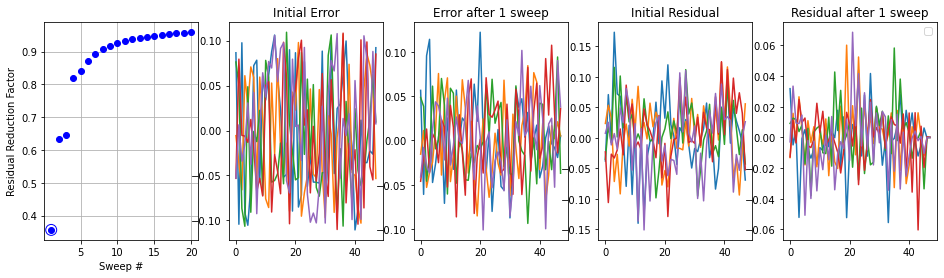

In [36]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20, x0=x0)
num_sweeps = method_info["Kaczmarz"][1]

In [39]:
def plot_svd_coarsening_accuracy(level, aggregate_size: int = 4):
    """Checks coarsening based on relaxed TVs, for different number of relaxation sweeps.
    If aggregate_size is not None, forces that aggregate size for the entire domain."""
    num_sweeps_values = 5 * 2 ** np.arange(8)

    fig, axs = plt.subplots(len(num_sweeps_values), 3, figsize=(16, 3 * len(num_sweeps_values)))
    x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=4 * aggregate_size)
    b = np.zeros_like(x_random)
    for row, num_sweeps in enumerate(num_sweeps_values):
        # Create relaxed TVs.
        x = hm.solve.run.run_iterative_method(
            level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]

        start, end = 0, aggregate_size
        x_aggregate_t = x[start:end].transpose()
        r, s = hm.repetitive.coarsening_repetitive.create_coarsening(x_aggregate_t, threshold)
        r = r.asarray()
        display(pd.DataFrame(r))

        # Relaxed vectors.
        ax = axs[row, 0]
        for i in range(min(3, x.shape[1])):
            ax.plot(x[:, i]);
        ax.grid(True)
        ax.set_title(r"Test Vectors, $\nu={}$ sweeps".format(num_sweeps))

        ax = axs[row, 1]
        # R should be real-valued, but cast just in case.
        for i, ri in enumerate(np.real(r)):
            ax.plot(ri)
        ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
        ax.set_ylabel(r"$R$ rows")
        ax.grid(True);

        # Singular values, normalized to sigma_max = 1.
        ax = axs[row, 2]
        ax.plot(s / s[0], "rx")
        ax.set_title("Singular Values")
        ax.set_xlabel(r"$k$")
        ax.set_ylabel(r"$\sigma_k$")
        ax.grid(True);

        # TODO: replace by local mock cycle rate.
        nu_values = np.arange(1, 12)
        R = hrc.Coarsener(r).tile(level.a.shape[0] // aggregate_size)
        print("nu", "{:3d}".format(num_sweeps), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)
        mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
        #hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
        _LOGGER.info("Mock cycle conv {}".format(np.array2string(mock_conv, precision=3)))

#         # Generate coarse variables (R) on the non-repetitive domain.
#         r, aggregates, nc, energy_error = hm.repetitive.coarsening_repetitive.create_coarsening_domain(
#             x, threshold=threshold, fixed_aggregate_size=aggregate_size)
#         _LOGGER.info("Agg {}".format(np.array([len(aggregate) for aggregate in aggregates])))
#         _LOGGER.info("nc  {}".format(nc))
#         _LOGGER.info("Energy error mean {:.4f} max {:.4f}".format(np.mean(energy_error), np.max(energy_error)))
#         mock_conv_factor = np.array(
#             [hm.setup.auto_setup.mock_cycle_conv_factor(level, r, nu) for nu in np.arange(1, 16, dtype=int)])
#         _LOGGER.info("Mock cycle conv factor {}".format(np.array2string(mock_conv_factor, precision=3)))

,0,1,2,3
0,-0.67,-0.28,0.67,-0.14
1,0.29,-0.64,0.17,0.69
2,0.60,0.35,0.71,-0.11


nu   5 s [1.    0.65  0.52  0.093] Energy error [0.642 0.405 0.071 0.   ]
INFO     Mock cycle conv [0.175 0.13  0.074 0.025 0.014 0.01  0.009 0.007 0.006 0.006 0.004]


,0,1,2,3
0,-0.70,-0.20,0.64,-0.24
1,0.49,-0.38,0.60,0.49
2,-0.40,-0.64,-0.46,0.47


nu  10 s [1.    0.536 0.373 0.059] Energy error [0.548 0.316 0.049 0.   ]
INFO     Mock cycle conv [0.197 0.133 0.064 0.024 0.016 0.011 0.007 0.006 0.005 0.004 0.003]


,0,1,2,3
0,-0.72,-0.16,0.60,-0.30
1,0.45,-0.41,0.65,0.45
2,-0.40,-0.67,-0.45,0.44


nu  20 s [1.    0.534 0.221 0.045] Energy error [0.501 0.195 0.039 0.   ]
INFO     Mock cycle conv [0.199 0.129 0.064 0.025 0.017 0.011 0.008 0.006 0.005 0.004 0.003]


,0,1,2,3
0,-0.75,-0.14,0.55,-0.33
1,-0.37,0.51,-0.64,-0.45
2,-0.41,-0.66,-0.53,0.34


nu  40 s [1.    0.595 0.13  0.028] Energy error [0.52  0.113 0.024 0.   ]
INFO     Mock cycle conv [0.193 0.092 0.055 0.023 0.014 0.012 0.01  0.007 0.006 0.005 0.004]


,0,1,2,3
0,-0.78,-0.09,0.49,-0.38
1,-0.27,0.55,-0.66,-0.43


nu  80 s [1.    0.681 0.056 0.013] Energy error [0.564 0.048 0.011 0.   ]
INFO     Mock cycle conv [0.511 0.318 0.251 0.216 0.179 0.144 0.13  0.12  0.105 0.099 0.089]


,0,1,2,3
0,-0.79,-0.05,0.45,-0.40
1,-0.22,0.57,-0.68,-0.41


nu 160 s [1.    0.747 0.01  0.003] Energy error [0.598 0.008 0.002 0.   ]
INFO     Mock cycle conv [0.492 0.316 0.217 0.174 0.16  0.152 0.115 0.128 0.116 0.104 0.096]


,0,1,2,3
0,-0.79,-0.05,0.45,-0.41
1,-0.21,0.57,-0.68,-0.41


nu 320 s [1.    0.758 0.    0.   ] Energy error [0.604 0.    0.    0.   ]
INFO     Mock cycle conv [0.48  0.296 0.205 0.18  0.151 0.142 0.138 0.131 0.119 0.107 0.097]


,0,1,2,3
0,-0.79,-0.05,0.45,-0.41
1,-0.21,0.57,-0.68,-0.41


nu 640 s [1.    0.758 0.    0.   ] Energy error [0.604 0.    0.    0.   ]
INFO     Mock cycle conv [0.516 0.298 0.202 0.19  0.15  0.155 0.14  0.123 0.111 0.108 0.098]


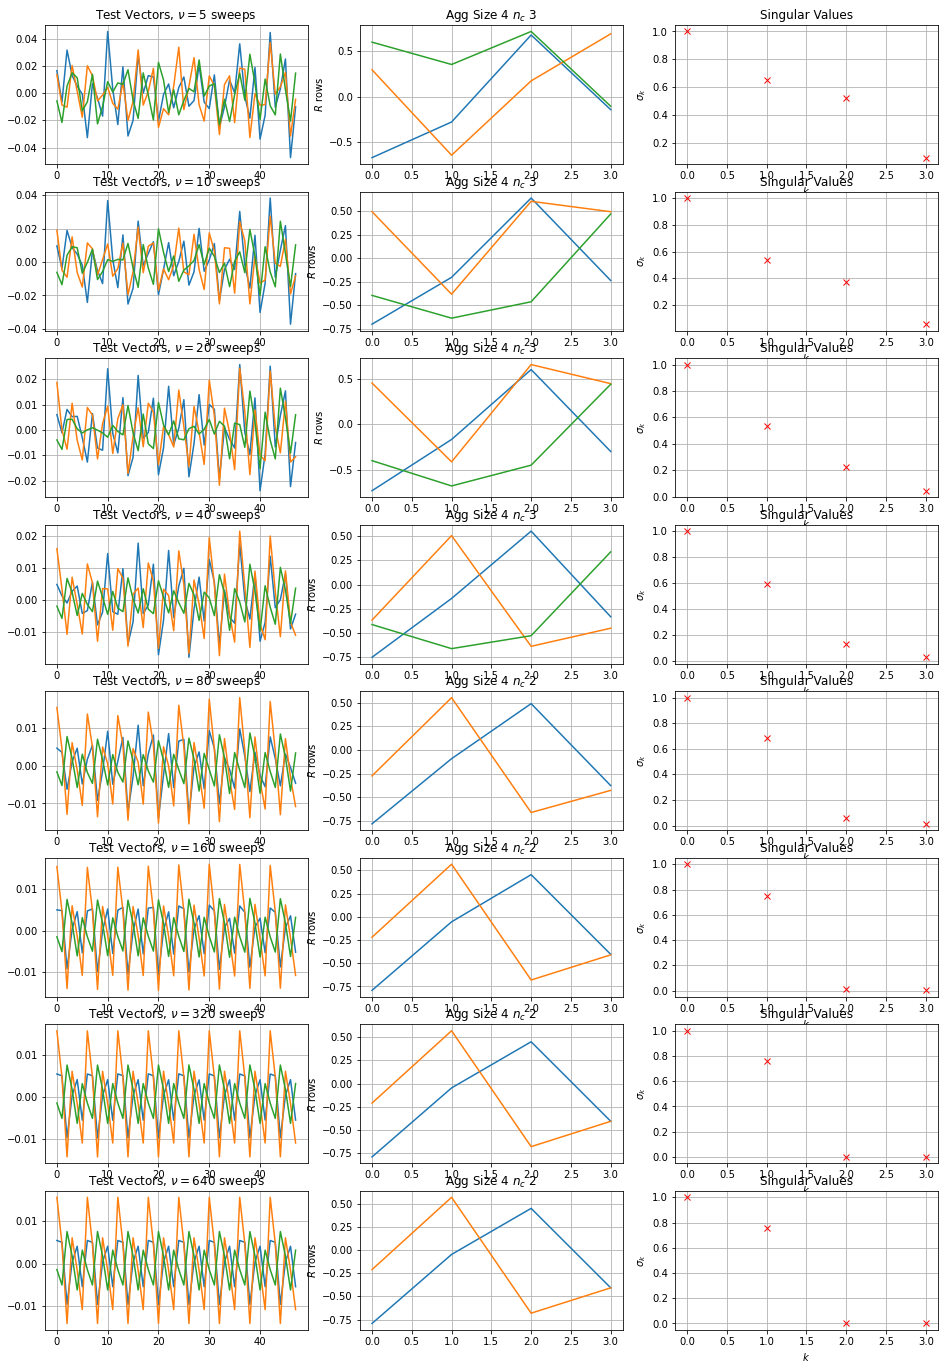

In [40]:
# #PCs revealed by relaxed vectors of increasing smoothness.
plot_svd_coarsening_accuracy(level, 4)

In [41]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = m1[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 6 ideal TVs


[[-0.676  0.135  0.507 -0.517]
 [-0.089  0.797 -0.555 -0.221]]
[1.    0.855 0.354 0.271]


,0,1,2,3,4,5,6,7,8,9
0,-0.68,0.14,0.51,-0.52,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.09,0.80,-0.56,-0.22,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,-0.68,0.14,0.51,-0.52,0.00,0.00
3,0.00,0.00,0.00,0.00,-0.09,0.80,-0.56,-0.22,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.68,0.14


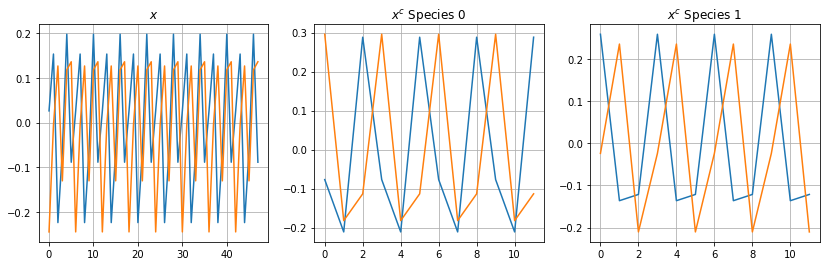

In [42]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
print(s/s[0])
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

In [43]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, 12)
mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
#hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.518 0.472 0.382 0.379 0.358 0.326 0.298 0.271 0.248 0.219 0.174]


In [ ]:
# Mock cycle rates
# Relaxed vectors: [0.52  0.435 0.425 0.341 0.355 0.327 0.295 0.272 0.248 0.225 0.204]
# Ideal vectors: [0.525 0.468 0.378 0.382 0.356 0.268 0.298 0.271 0.247 0.225 0.204]